## Importing  

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


Loading dataset

In [2]:
df = pd.read_csv("../data/production_volume.csv")

# Converting date column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%b-%Y")

# Creating a list of the products 
products = df.columns[1:]

# Creating a column for "year"
df["year"] = df["date"].dt.year

Visualizing the data structure

In [3]:
display(df.head(3))

,date,cheese,milk,dulce_leche,eggs,porks,vegetables,year
0,2020-01-01,20,300,5,1,1,10,2020
1,2020-02-01,25,310,3,2,1,12,2020
2,2020-03-01,28,320,4,5,1,18,2020


Visualizing the Annual Volume

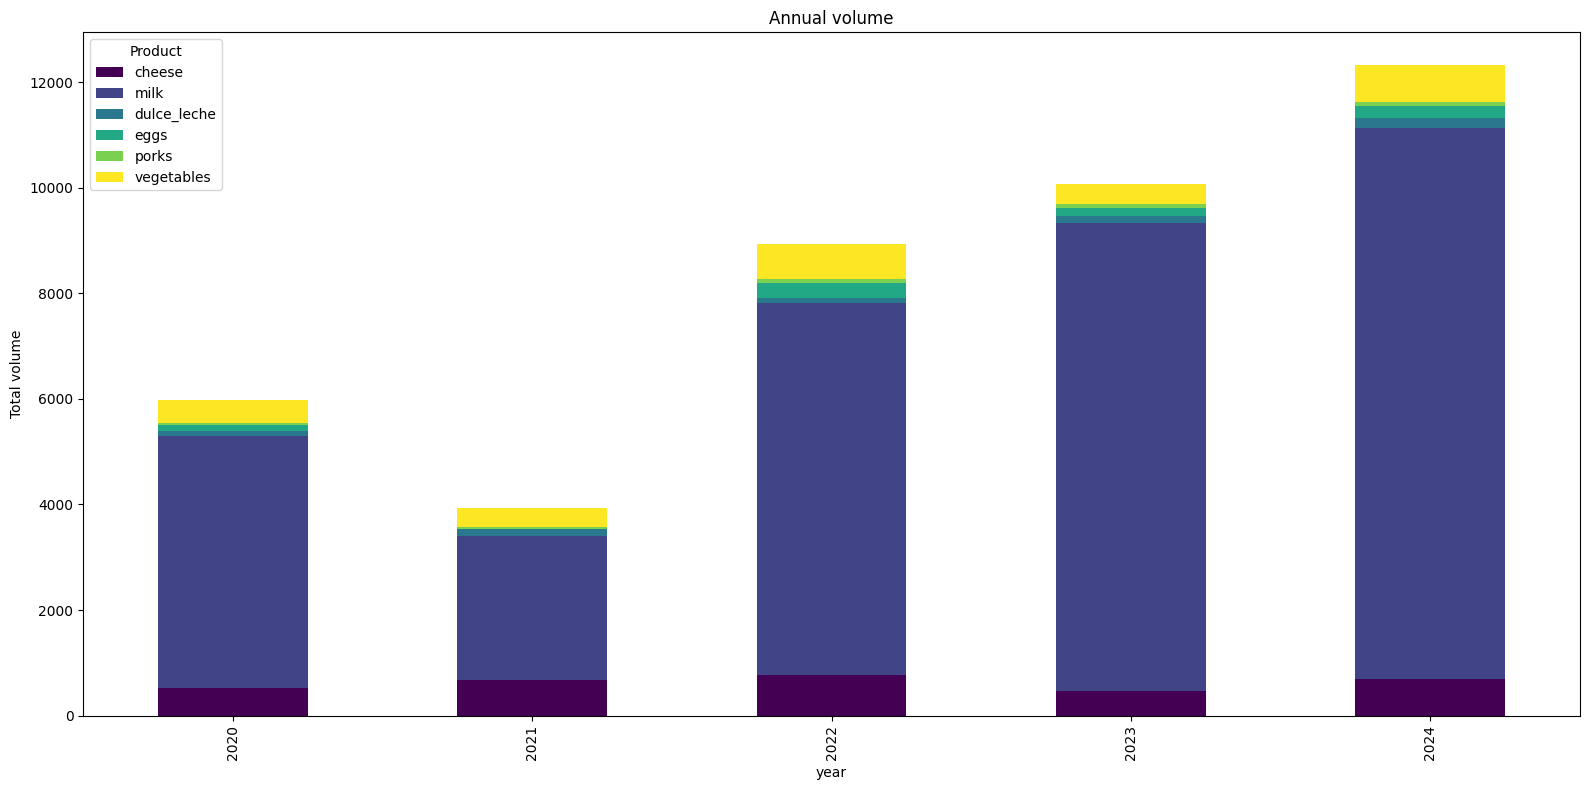

In [4]:
annual_volume = df.groupby("year")[products].sum()
annual_volume.plot(kind="bar", stacked=True, figsize=(16, 8), colormap="viridis")
plt.title("Annual volume")
plt.xlabel("year")
plt.ylabel("Total volume")
plt.legend(title="Product")
plt.tight_layout()
plt.show()

In [5]:
df = df.drop(columns="year") # Drops the "year" column

Visualizing the total volume distribution by products

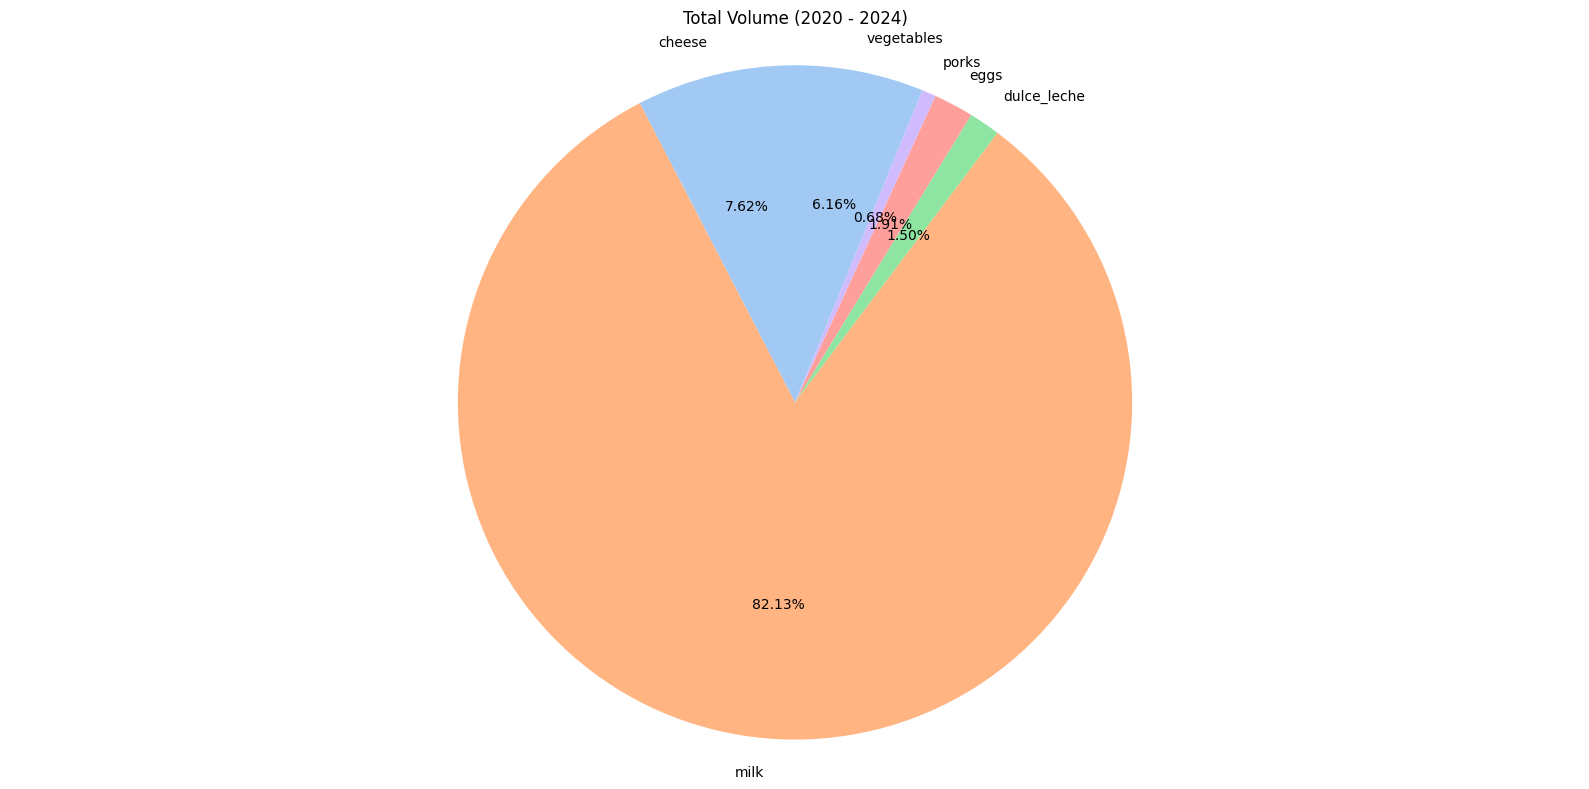

In [6]:
units_total = df.iloc[:, 1:].sum()
labels = units_total.index.tolist()
values = units_total.values.tolist()

colors = sns.color_palette("pastel")[0:5]
plt.figure(figsize=(16, 8))
plt.pie(
    values,
    labels=labels,
    autopct="%1.2f%%",
    startangle=90,
    colors=colors
)
plt.title("Total Volume (2020 - 2024)")
plt.axis("equal")
plt.tight_layout()
plt.show()

Visualizing products production thoughout the years

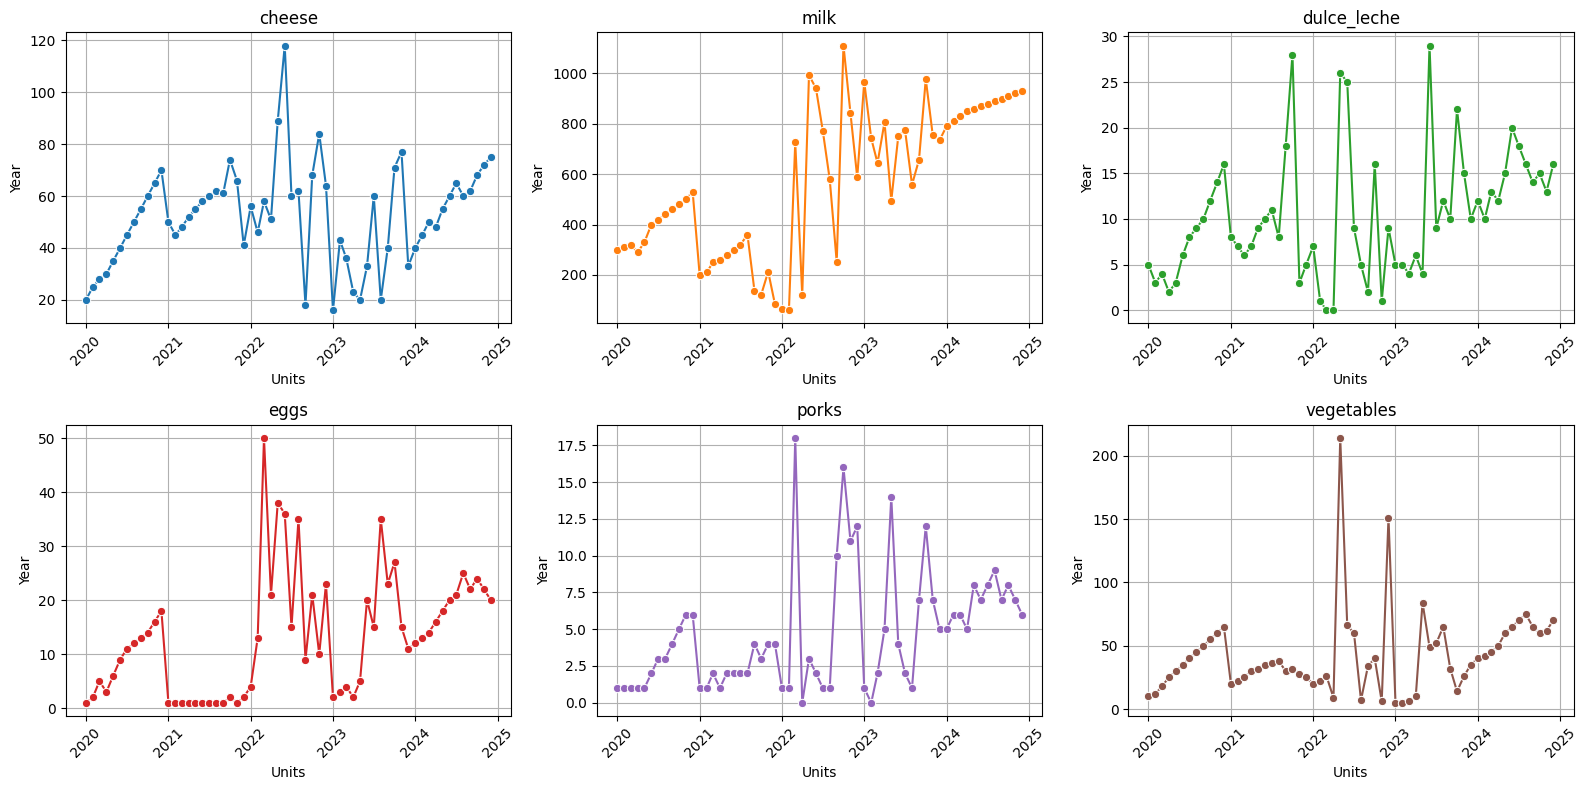

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, product in enumerate(products):
    ax = axes[i]
    sns.lineplot(data=df, x="date", y=product, marker="o", ax=ax, color=colors[i])
    ax.set_title(product)
    ax.set_ylabel("Year")
    ax.set_xlabel("Units")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

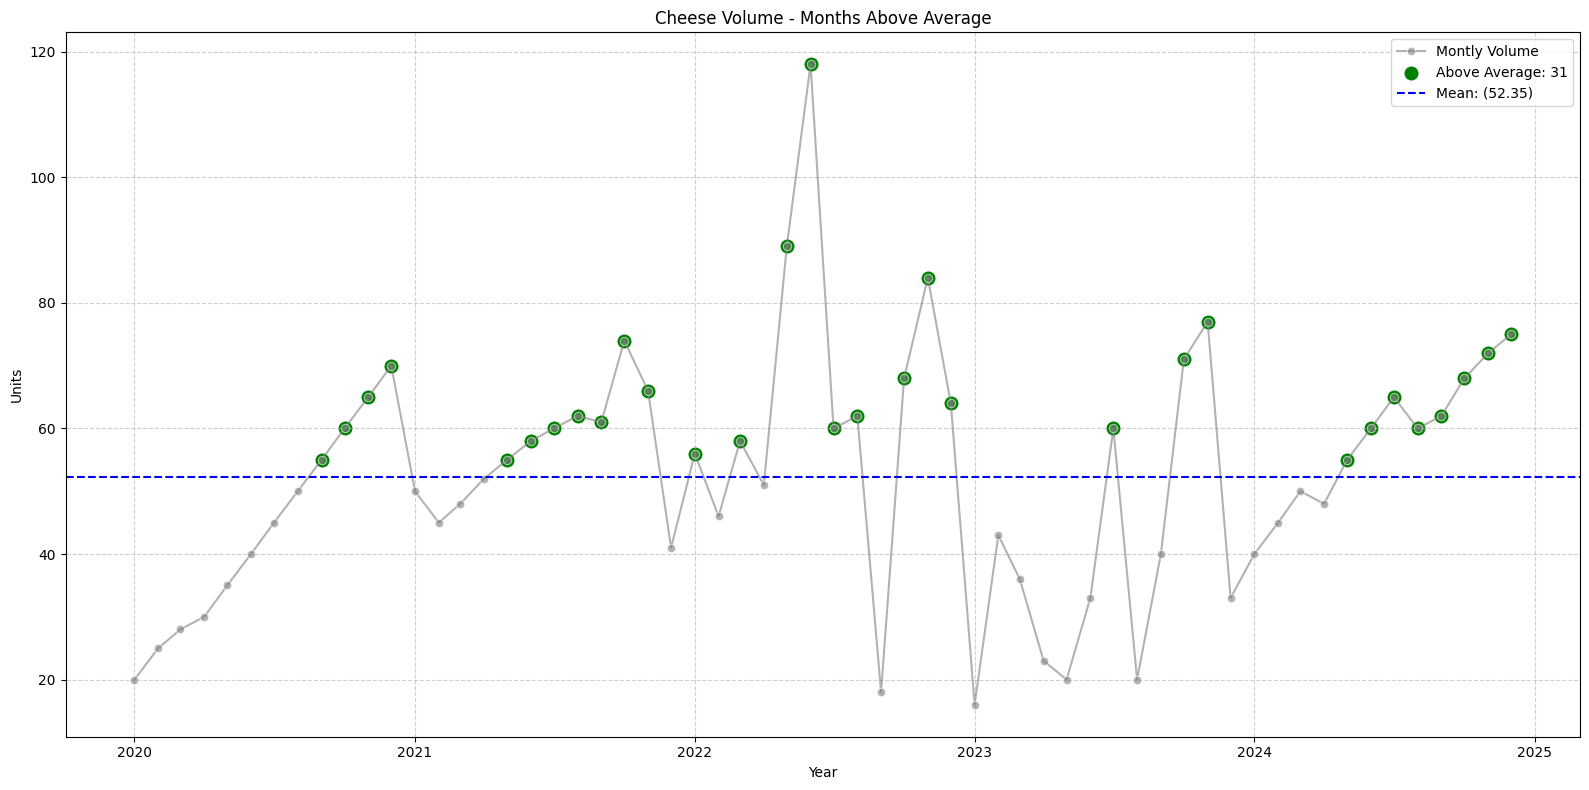

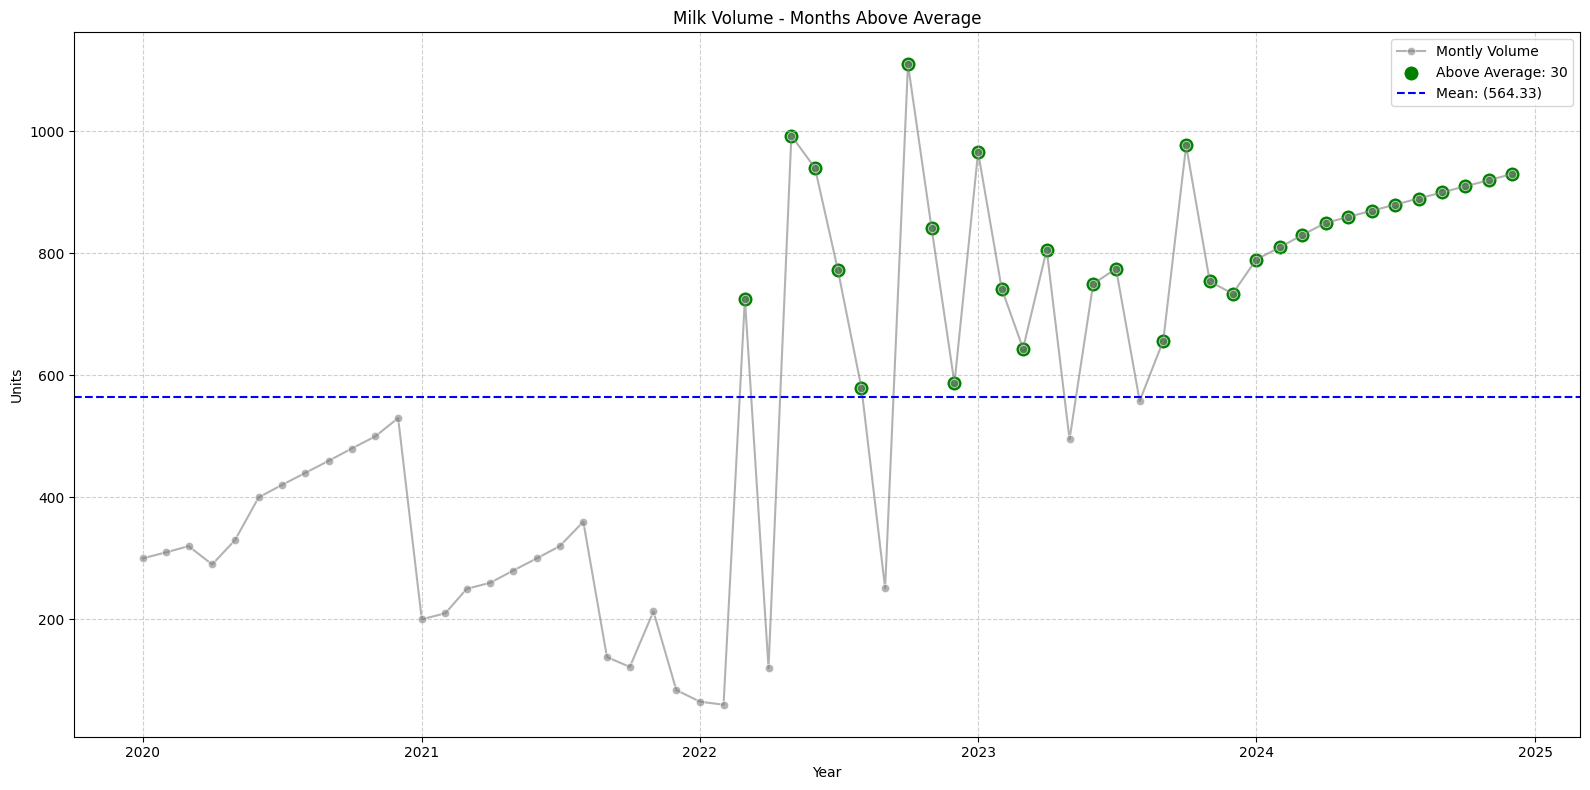

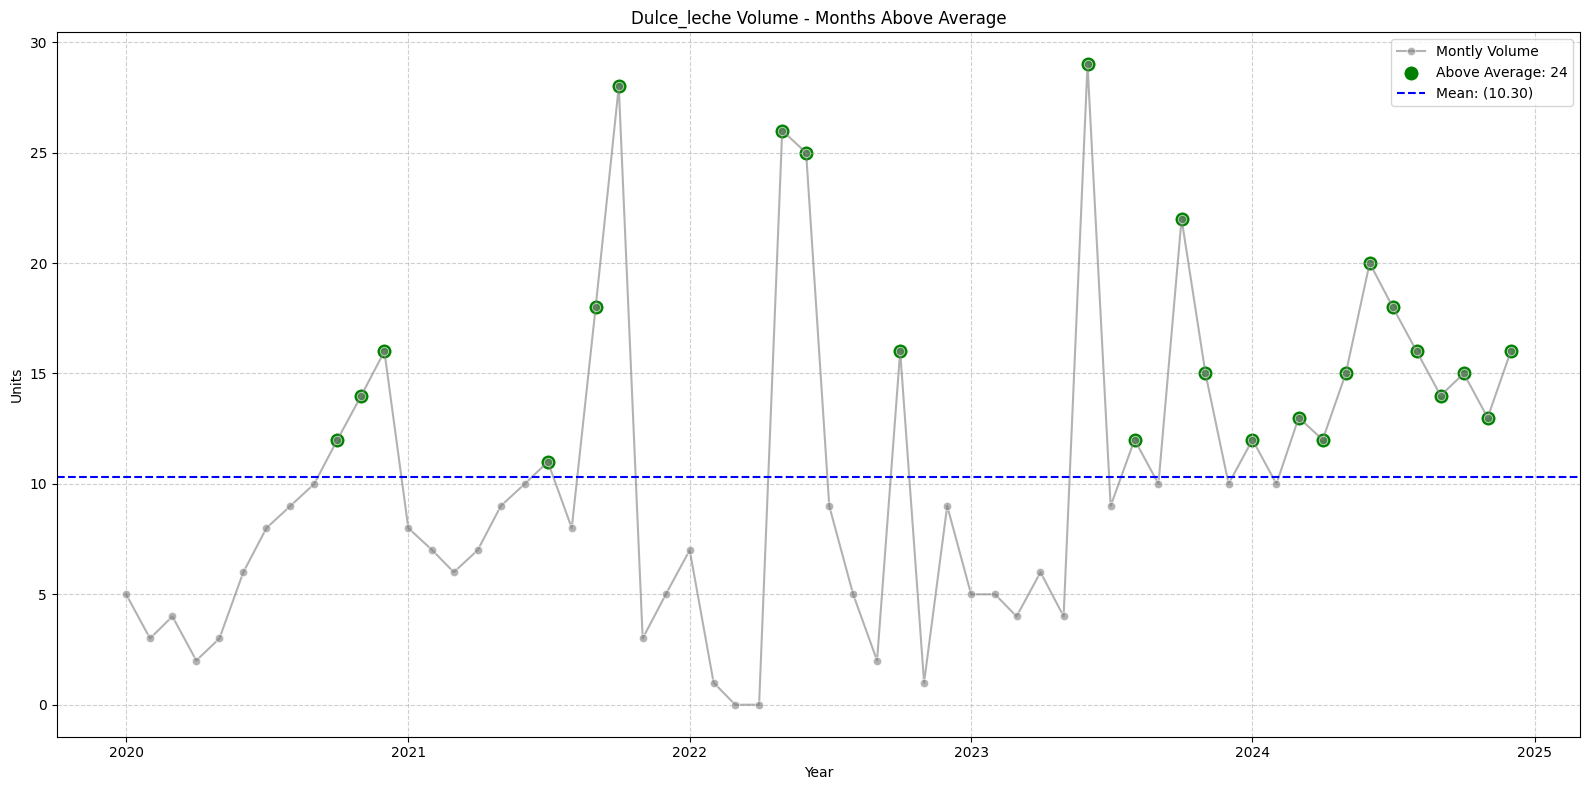

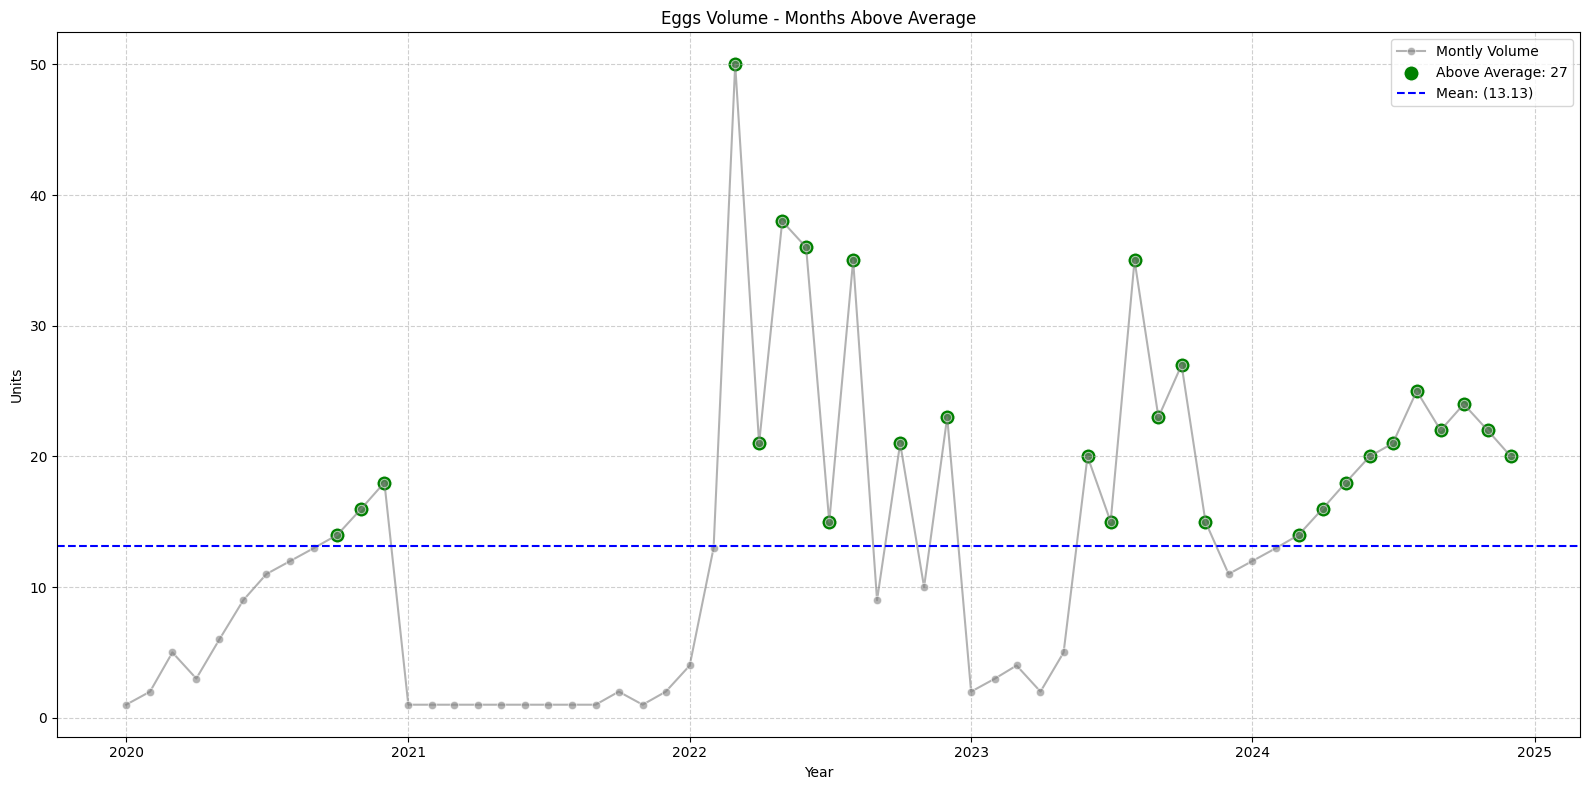

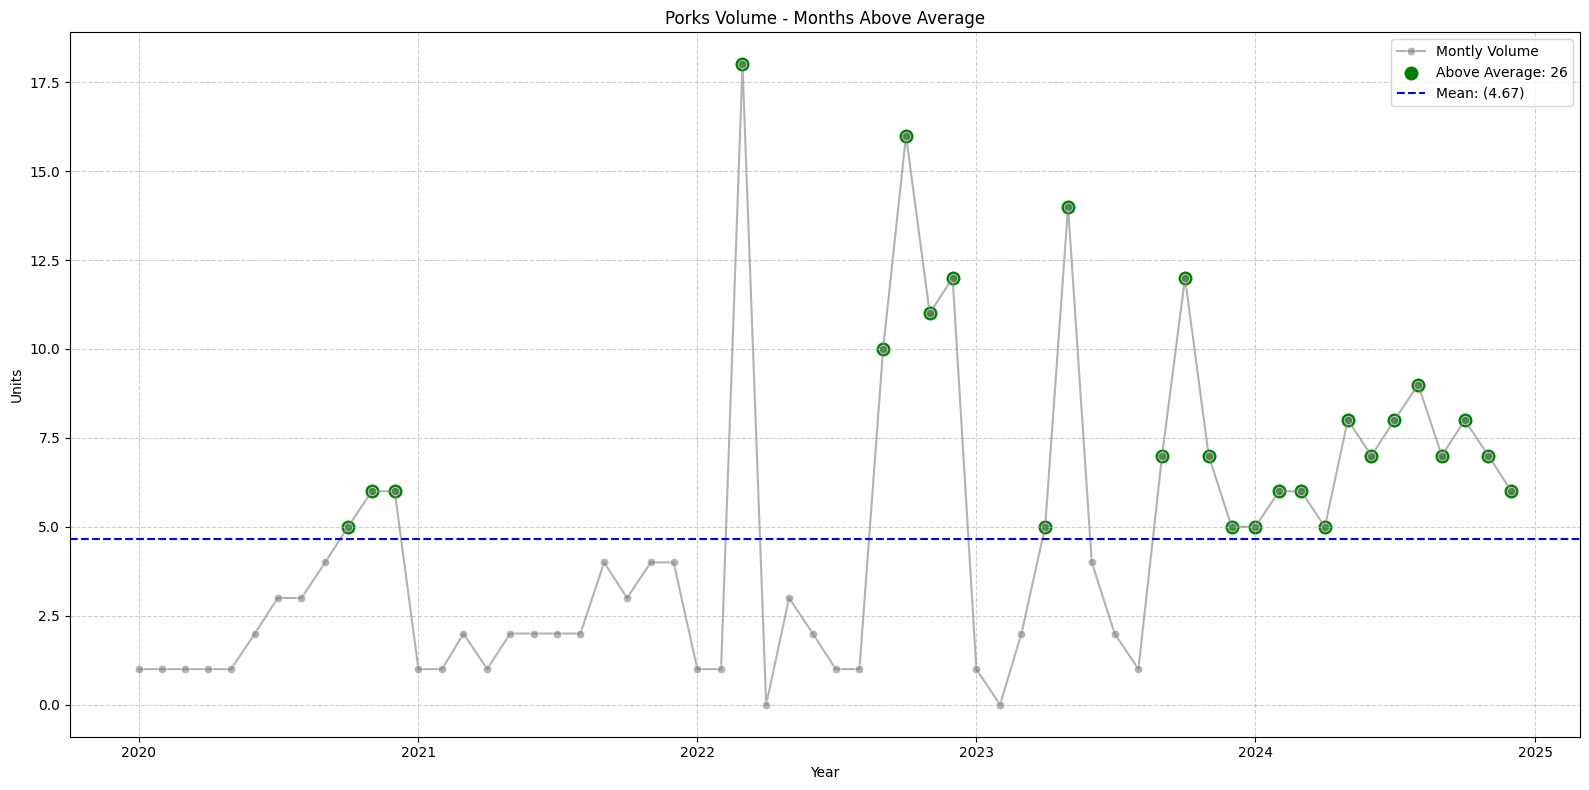

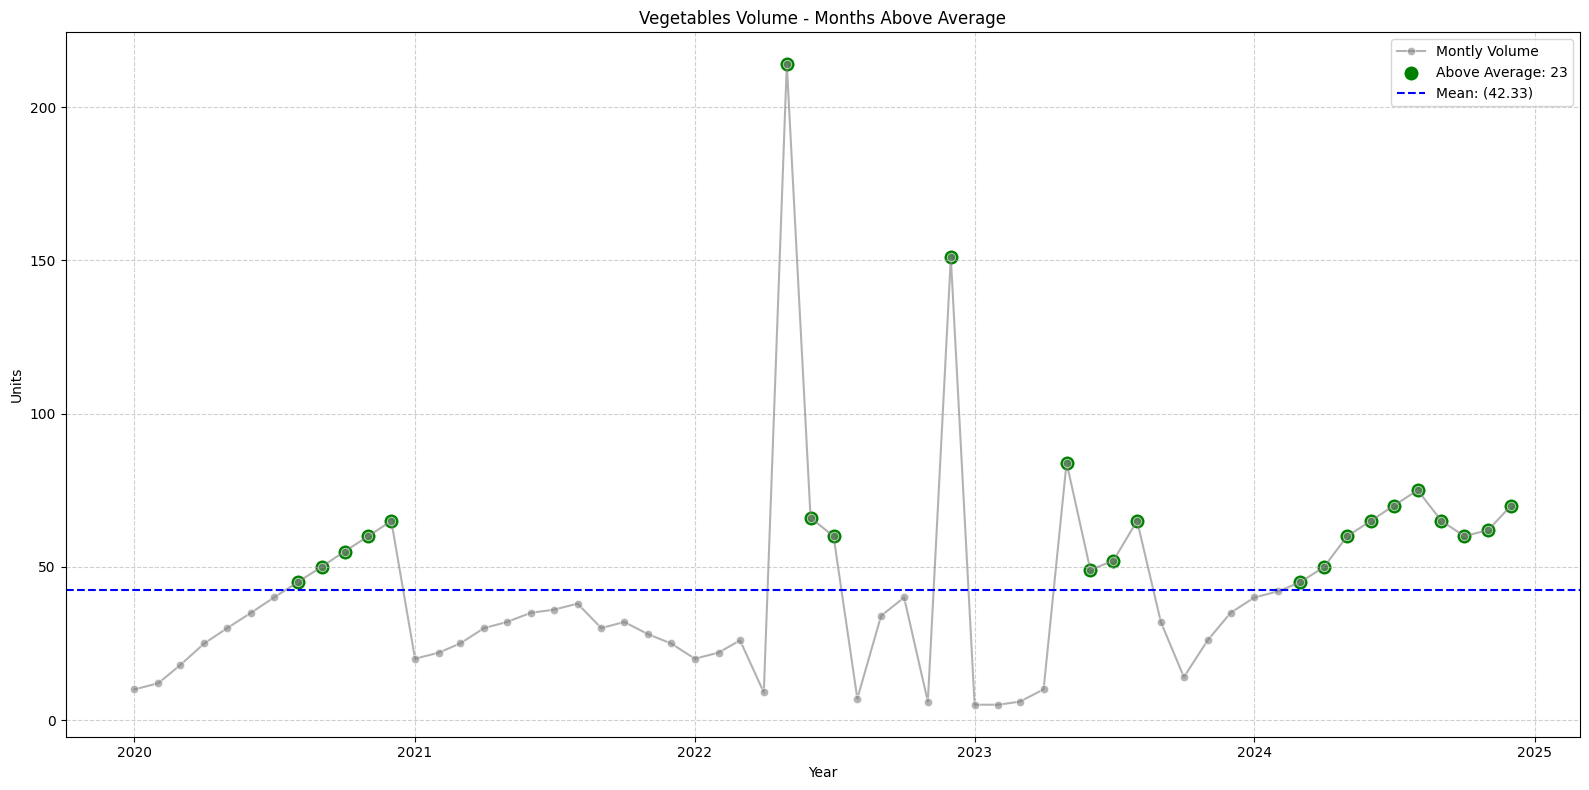

In [8]:
for product in products:
    mean = df[product].mean()

    plt.figure(figsize=(16, 8))

    sns.lineplot(
        data=df,
        x="date",
        y=product,
        marker="o",
        color="gray",
        label="Montly Volume",
        alpha=0.6
    )

    above_avg = df[df[product] > mean]
    sns.scatterplot(
        data=above_avg,
        x="date",
        y=product,
        color="green",
        marker="o",
        s=120,
        label=f"Above Average: {len(above_avg)}"
    )

    plt.axhline(mean, color="blue", linestyle="--", label=f"Mean: ({mean:.2f})")

    plt.title(f"{product.capitalize()} Volume - Months Above Average")
    plt.ylabel("Units")
    plt.xlabel("Year")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

Visualizing the very low products correlation 

Text(0.5, 1.0, 'Products Corrrelation')

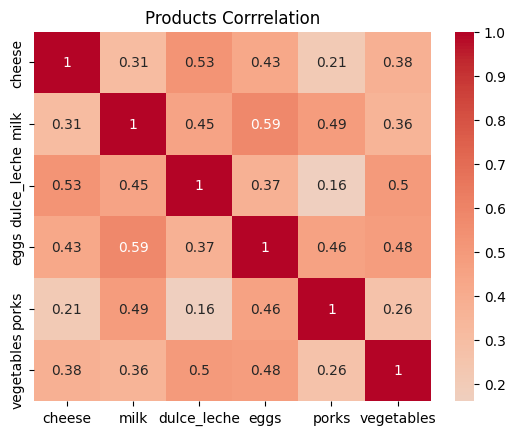

In [9]:
sns.heatmap(df[products].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Products Corrrelation")

Visualizing Outliers

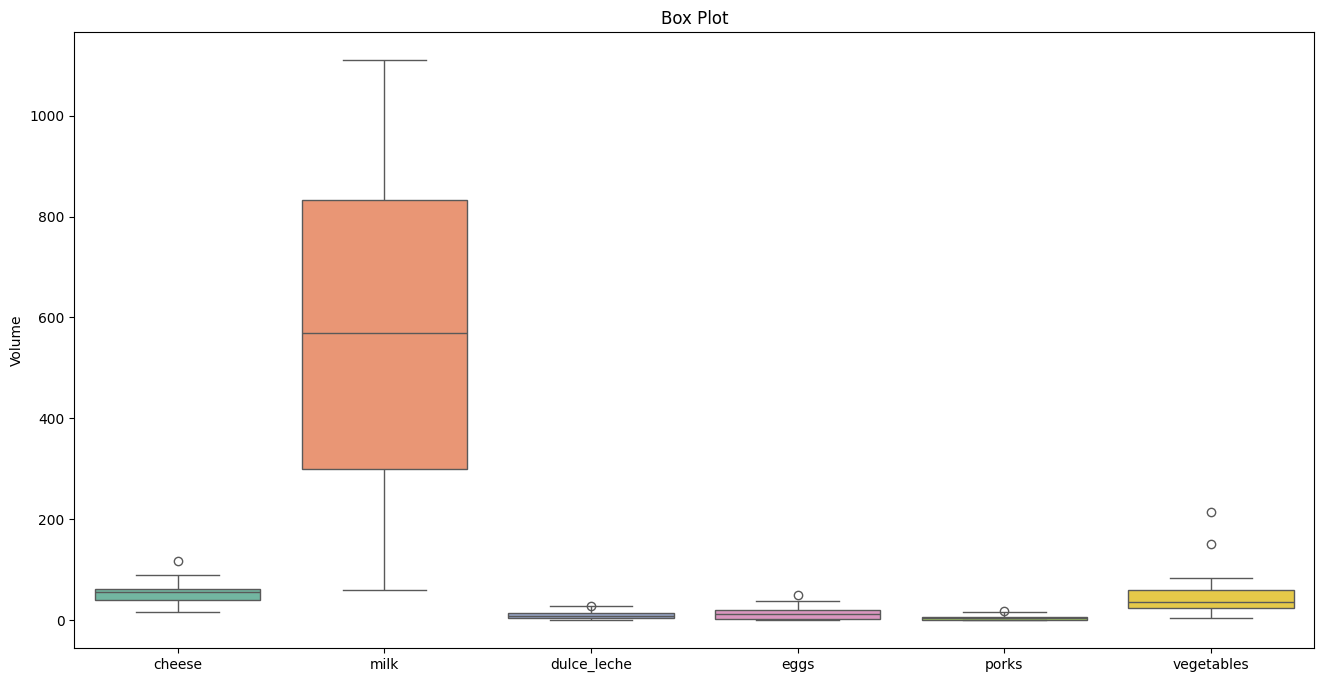

In [10]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[products], palette="Set2")
plt.title("Box Plot")
plt.ylabel("Volume")
plt.show()

Outliers analysis


Outlier Analysis - Column: cheese
• 1st Quartile (Q1): 40.00
• 3rd Quartile (Q3): 62.50
• IQR: 22.50
• Lower Bound: 6.25
• Upper Bound: 96.25
• Outliers Detected: 1


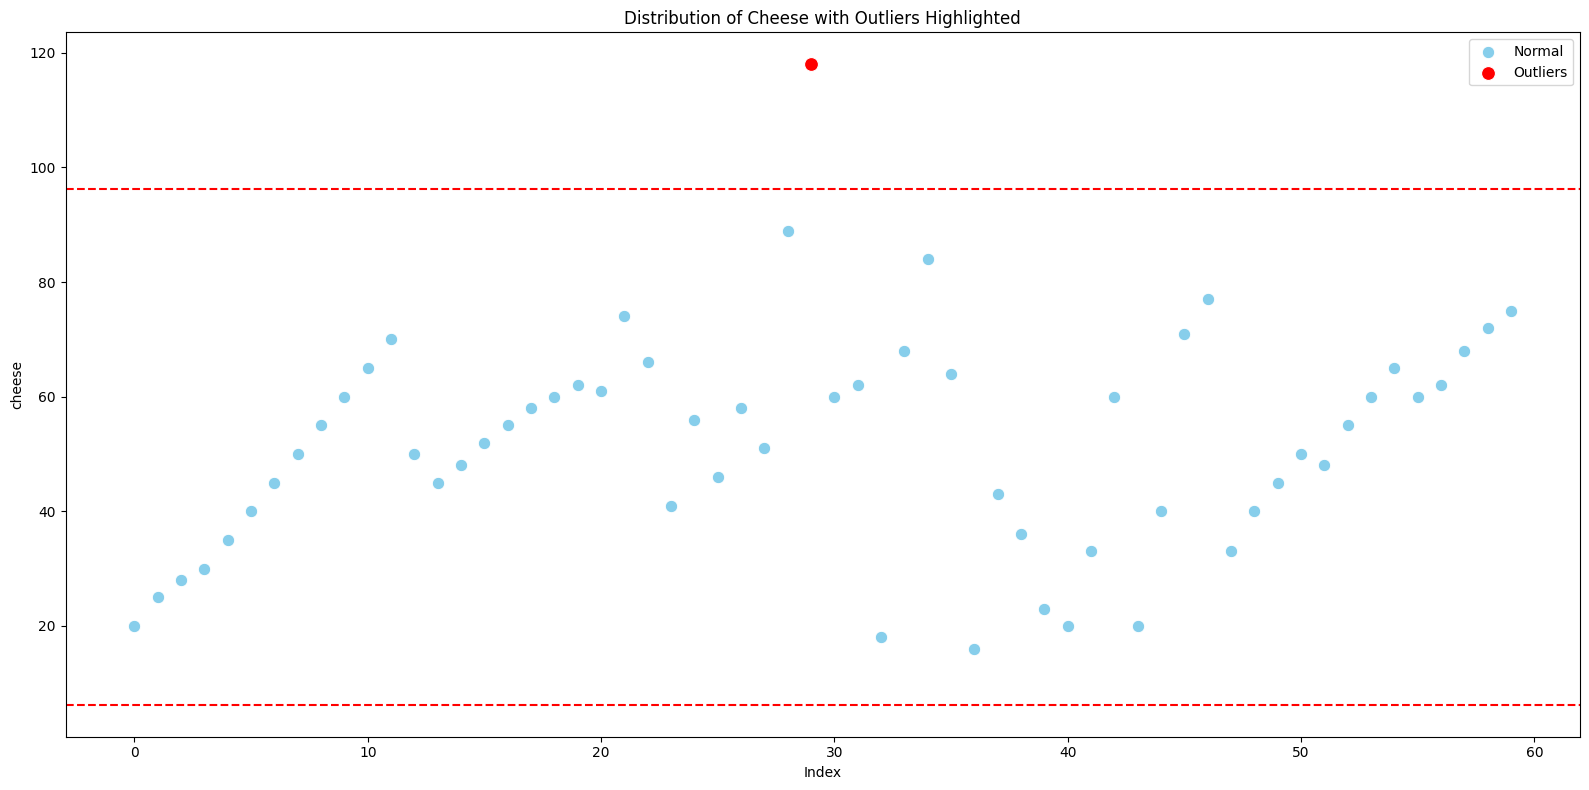


Outlier Analysis - Column: milk
• 1st Quartile (Q1): 300.00
• 3rd Quartile (Q3): 832.75
• IQR: 532.75
• Lower Bound: -499.12
• Upper Bound: 1631.88
• Outliers Detected: 0


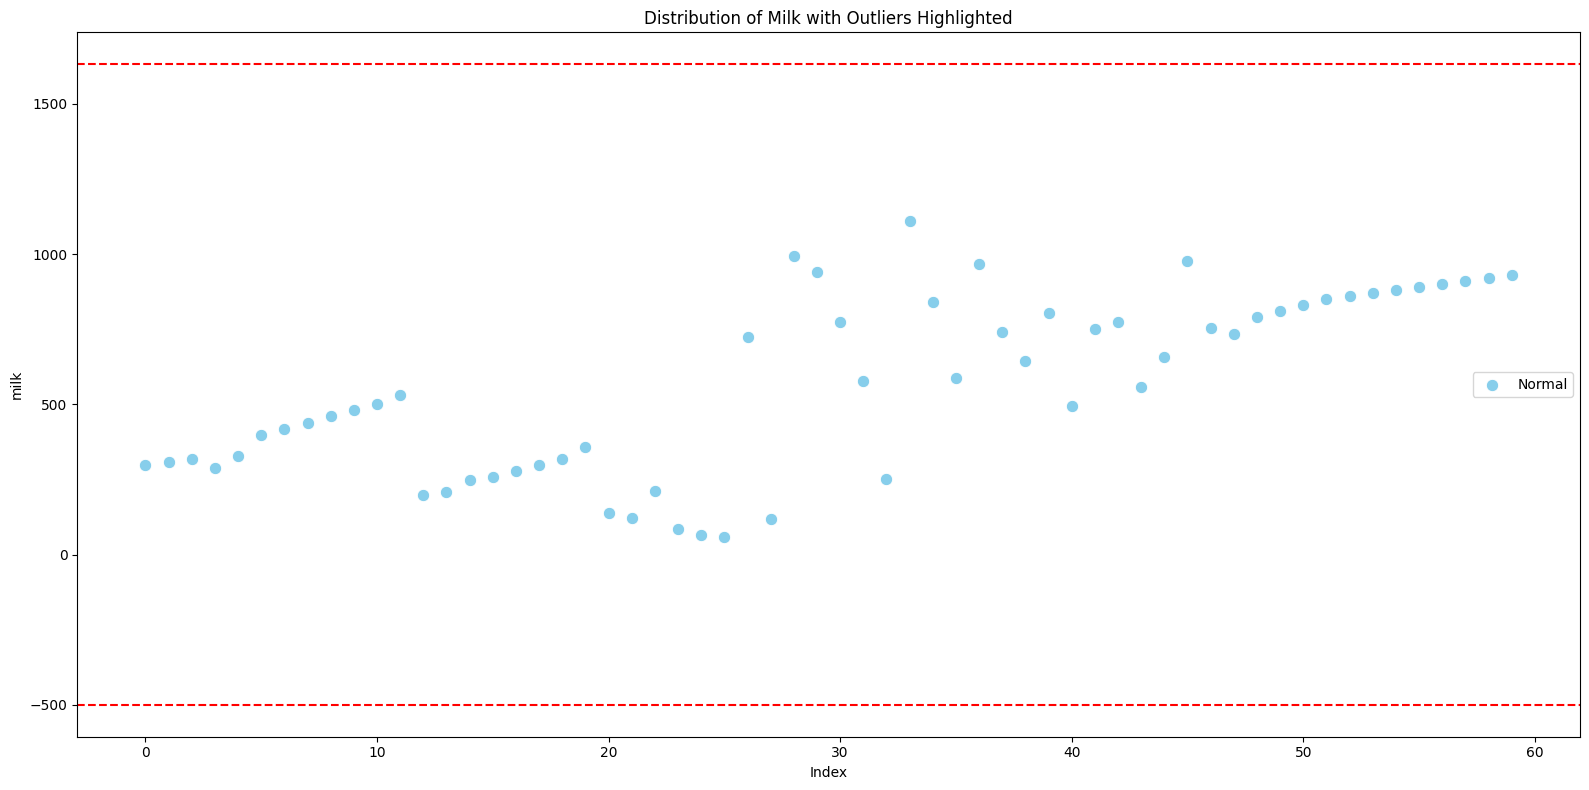


Outlier Analysis - Column: dulce_leche
• 1st Quartile (Q1): 5.00
• 3rd Quartile (Q3): 14.25
• IQR: 9.25
• Lower Bound: -8.88
• Upper Bound: 28.12
• Outliers Detected: 1


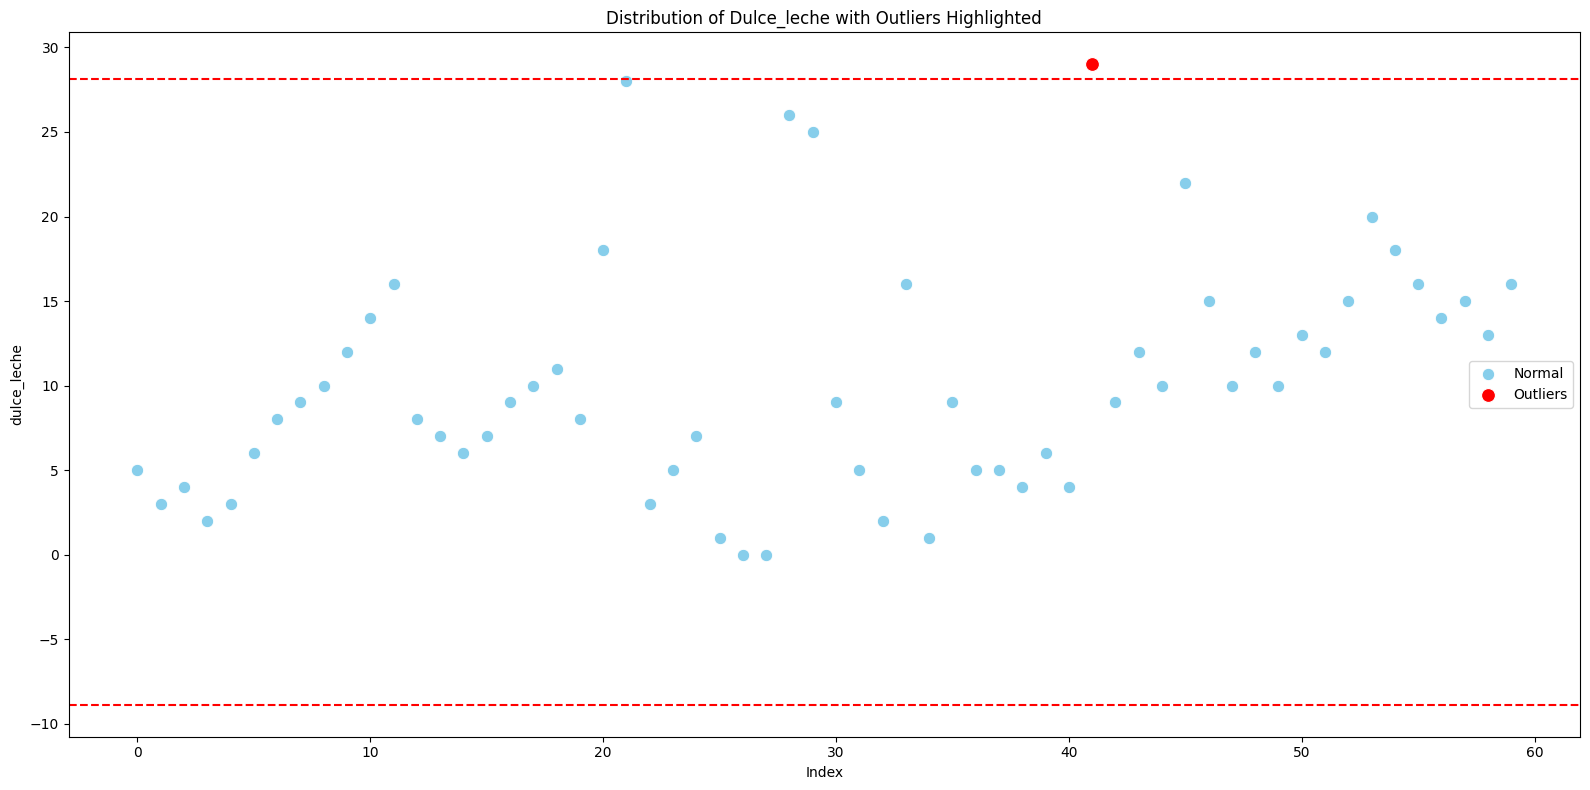


Outlier Analysis - Column: eggs
• 1st Quartile (Q1): 2.00
• 3rd Quartile (Q3): 20.25
• IQR: 18.25
• Lower Bound: -25.38
• Upper Bound: 47.62
• Outliers Detected: 1


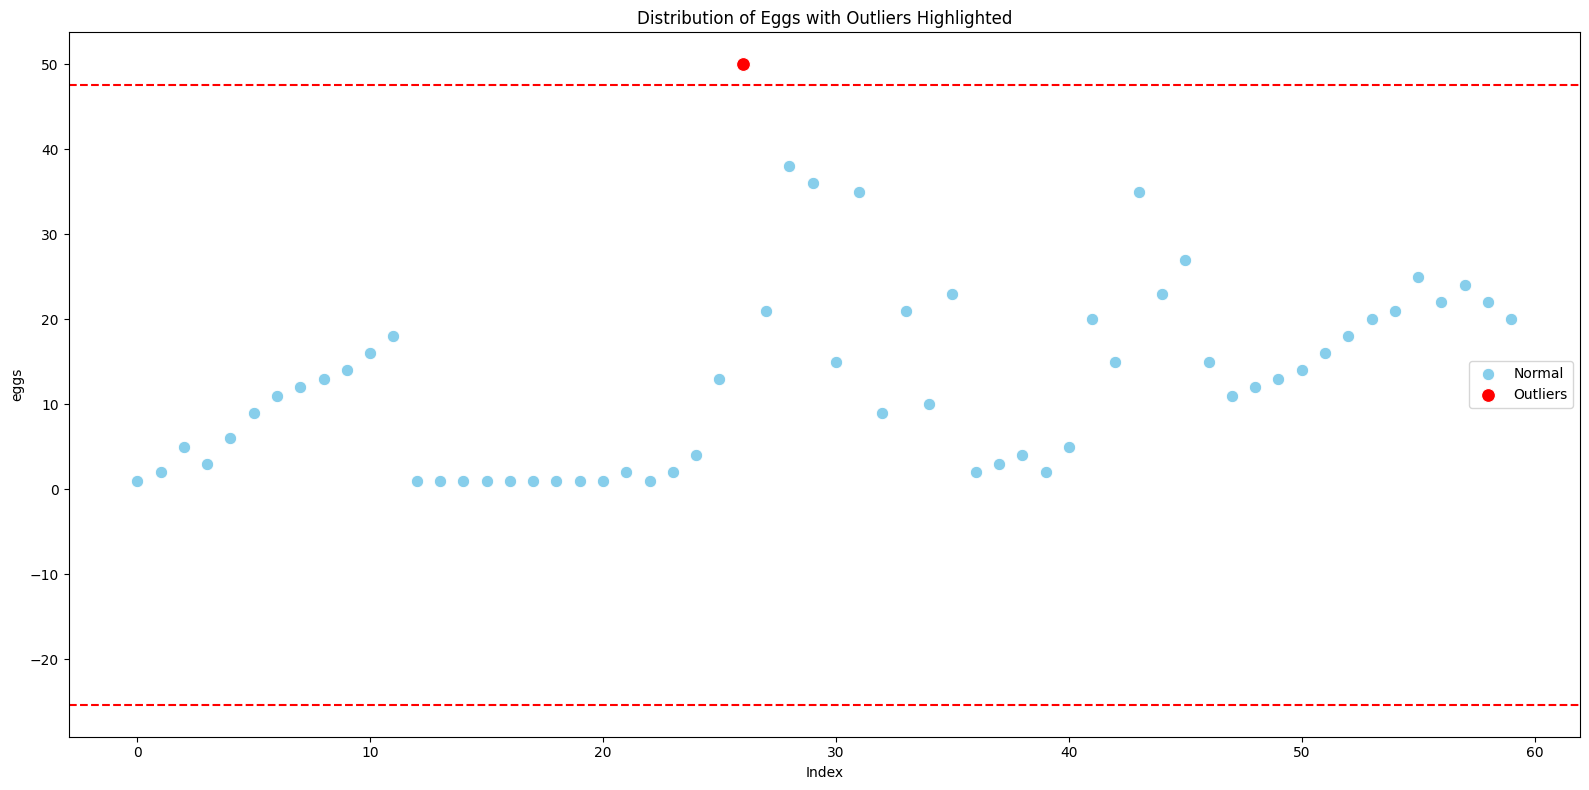


Outlier Analysis - Column: porks
• 1st Quartile (Q1): 1.00
• 3rd Quartile (Q3): 7.00
• IQR: 6.00
• Lower Bound: -8.00
• Upper Bound: 16.00
• Outliers Detected: 1


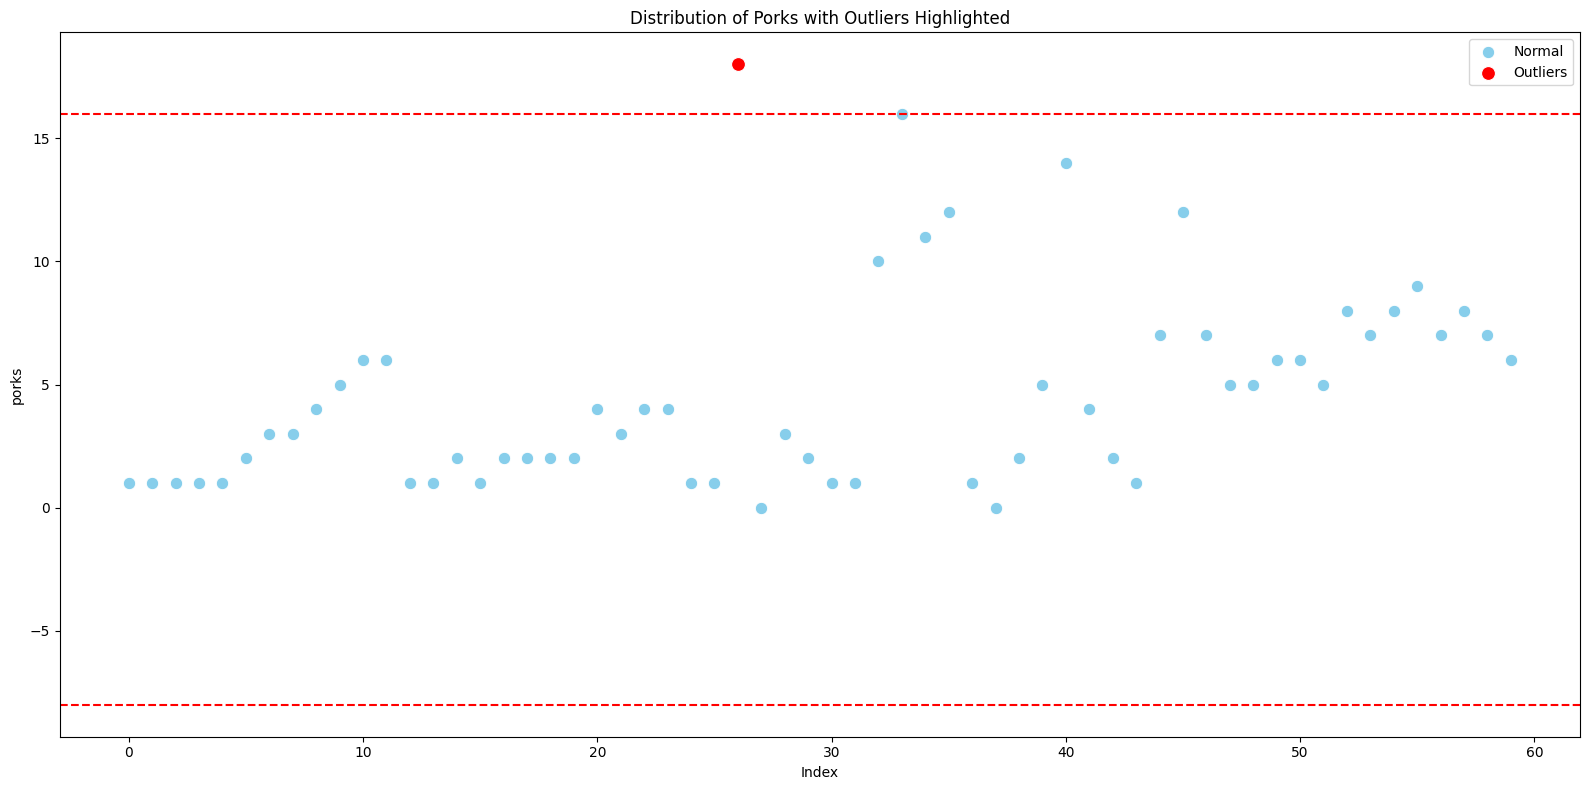


Outlier Analysis - Column: vegetables
• 1st Quartile (Q1): 24.25
• 3rd Quartile (Q3): 60.00
• IQR: 35.75
• Lower Bound: -29.38
• Upper Bound: 113.62
• Outliers Detected: 2


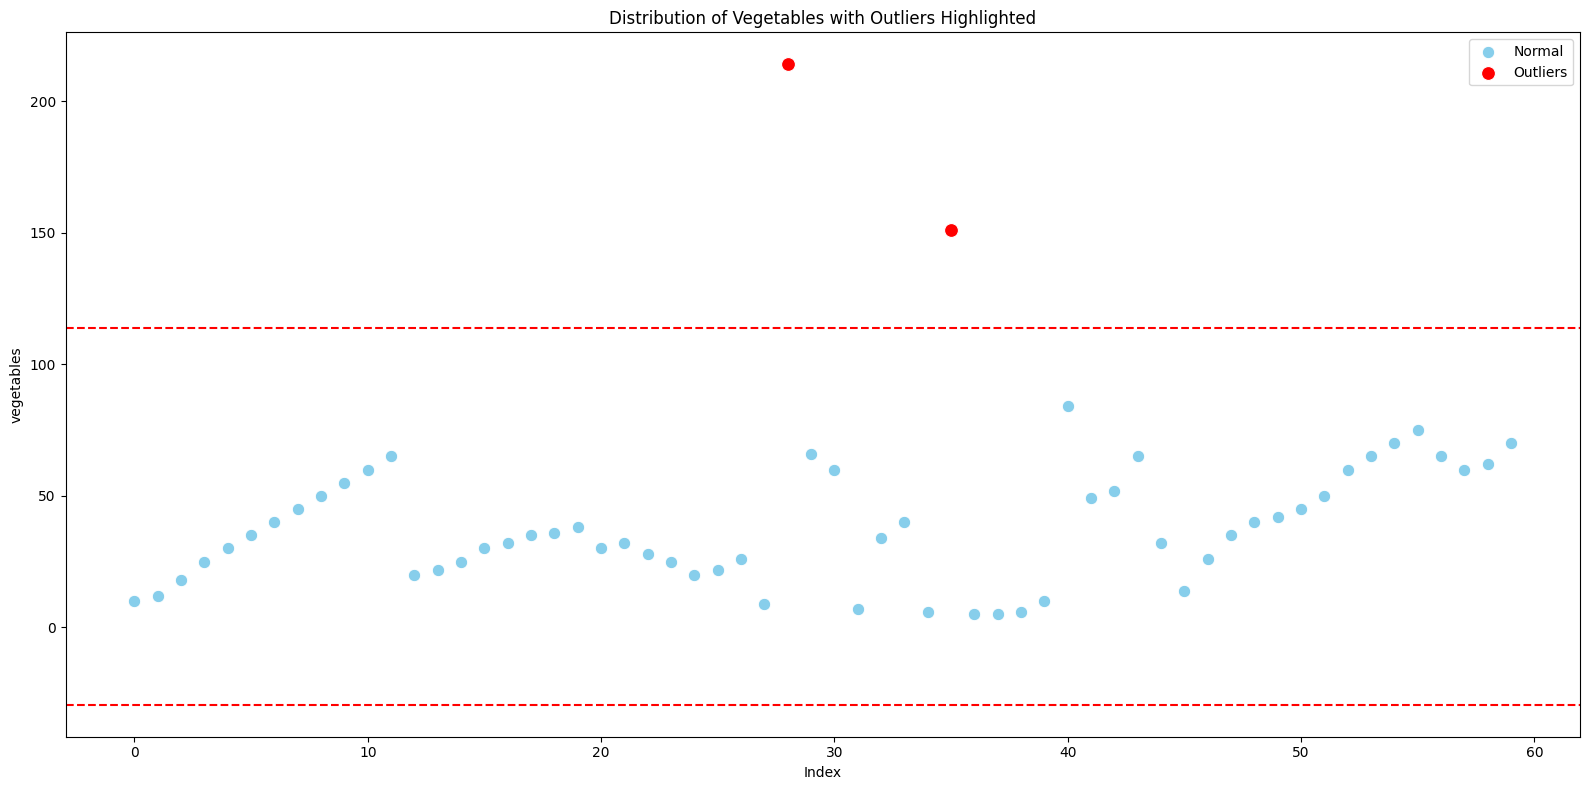

In [11]:
for product in products:
    Q1 = df[product].quantile(0.25)
    Q3 = df[product].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (df[product] < lower_bound) | (df[product] > upper_bound)
    outliers_df = df[outliers_mask].copy()
    non_outliers_df = df[~outliers_mask].copy()

    print(f"\nOutlier Analysis - Column: {product}")
    print(f"• 1st Quartile (Q1): {Q1:.2f}")
    print(f"• 3rd Quartile (Q3): {Q3:.2f}")
    print(f"• IQR: {IQR:.2f}")
    print(f"• Lower Bound: {lower_bound:.2f}")
    print(f"• Upper Bound: {upper_bound:.2f}")
    print(f"• Outliers Detected: {len(outliers_df)}")

    plt.figure(figsize=(16, 8))

    sns.scatterplot(x=non_outliers_df.index, y=non_outliers_df[product], color="skyblue", label="Normal", s=80)
    sns.scatterplot(x=outliers_df.index, y=outliers_df[product], color="red", label="Outliers", s=100) 
    plt.axhline(upper_bound, color="red", linestyle="--")
    plt.axhline(lower_bound, color="red", linestyle="--")

    plt.title(f"Distribution of {product.capitalize()} with Outliers Highlighted")
    plt.xlabel("Index")
    plt.ylabel(product)
    plt.legend()
    plt.tight_layout()
    plt.show()

Annual Trend and Monthly Seasonality

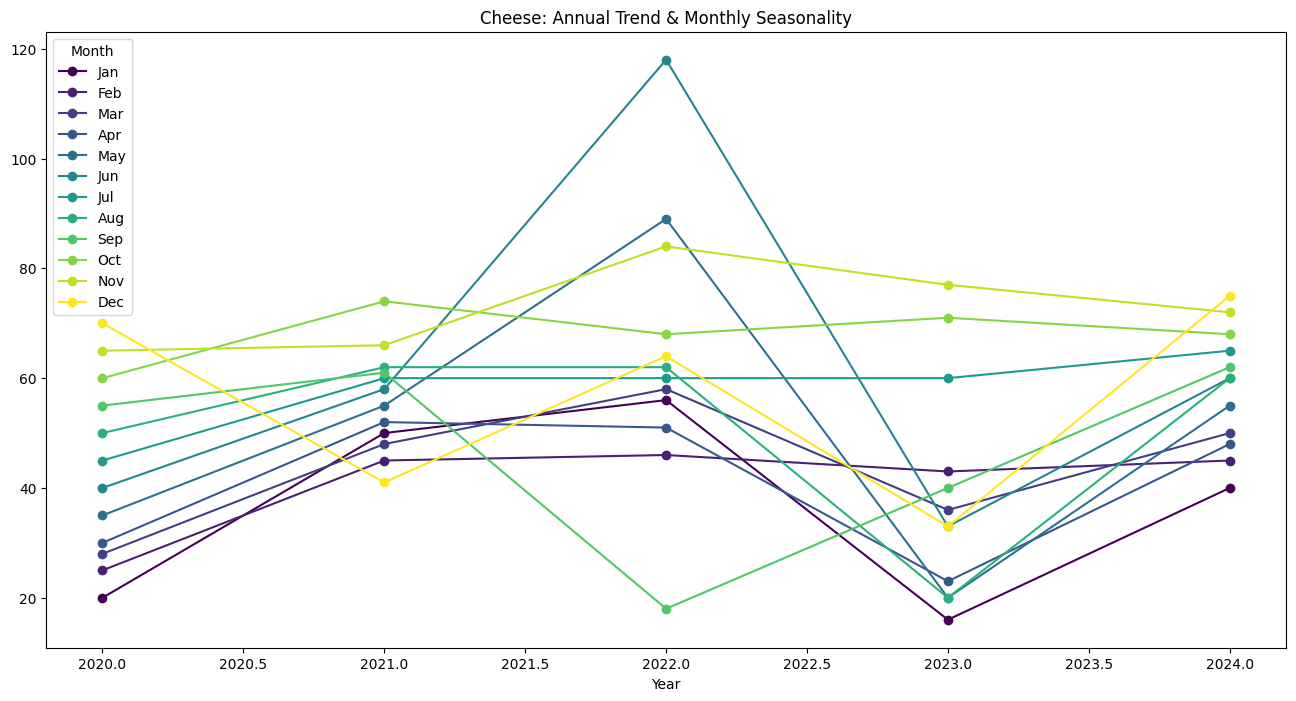

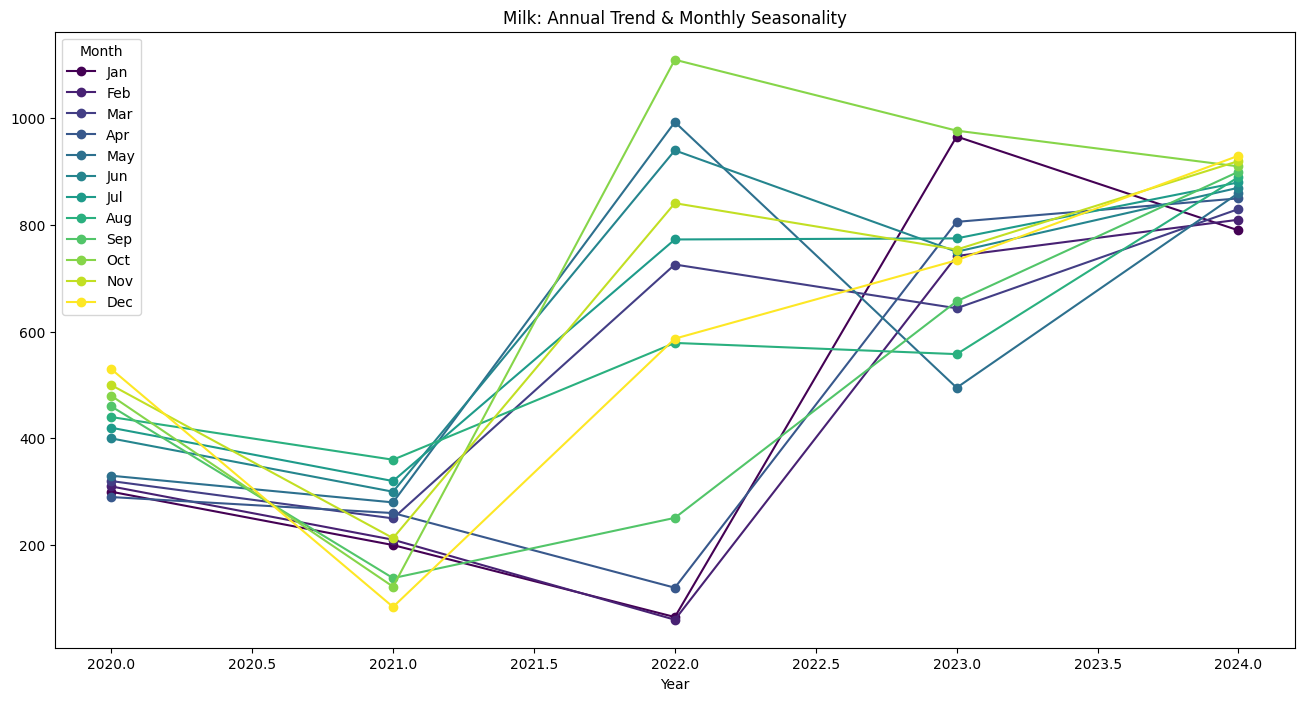

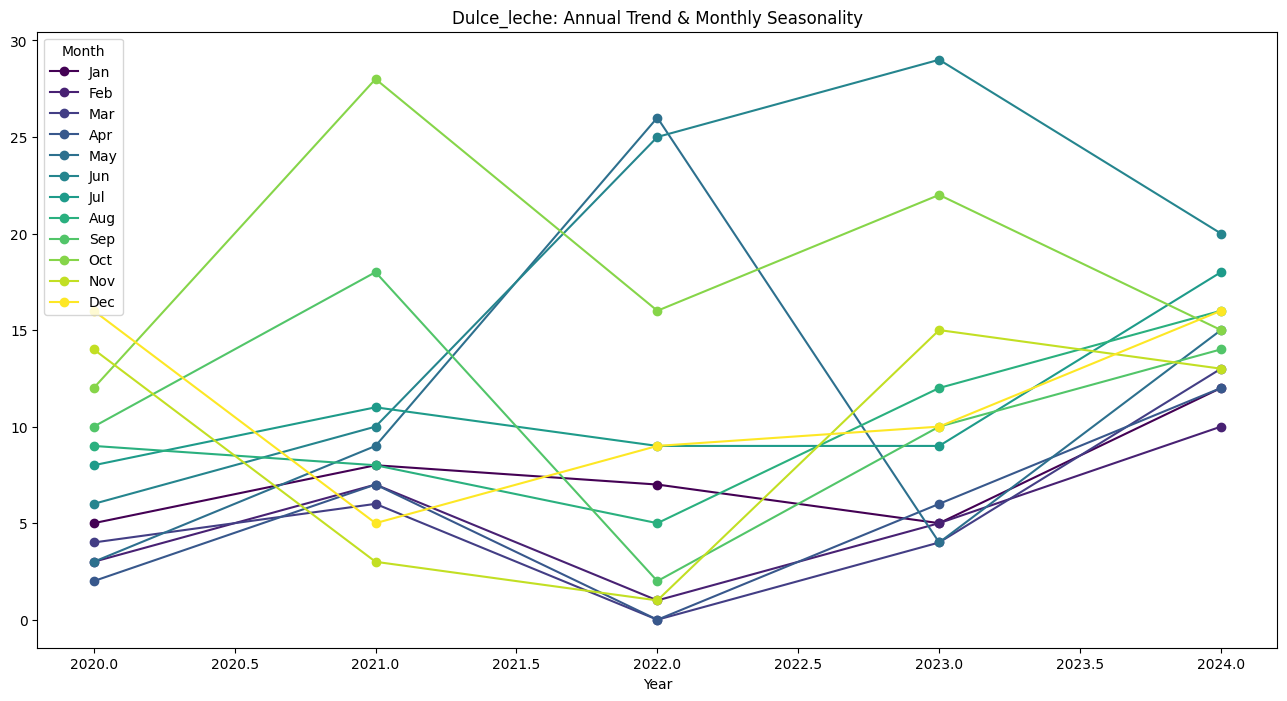

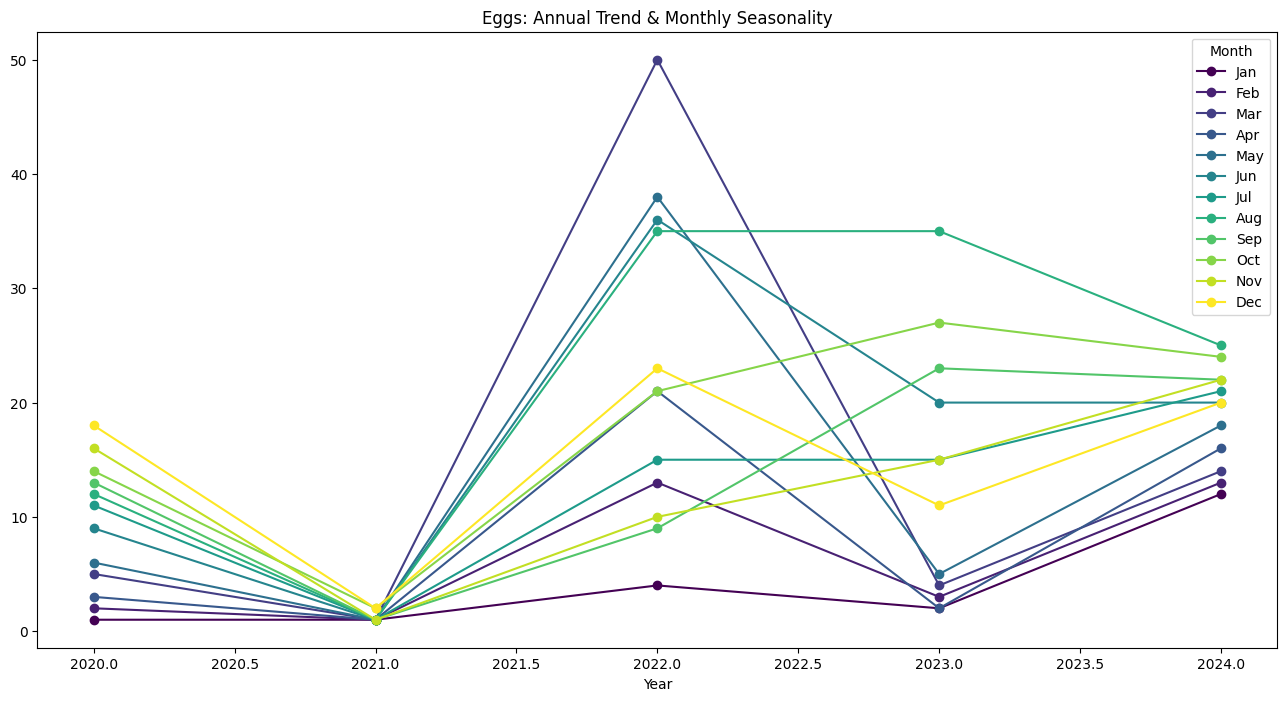

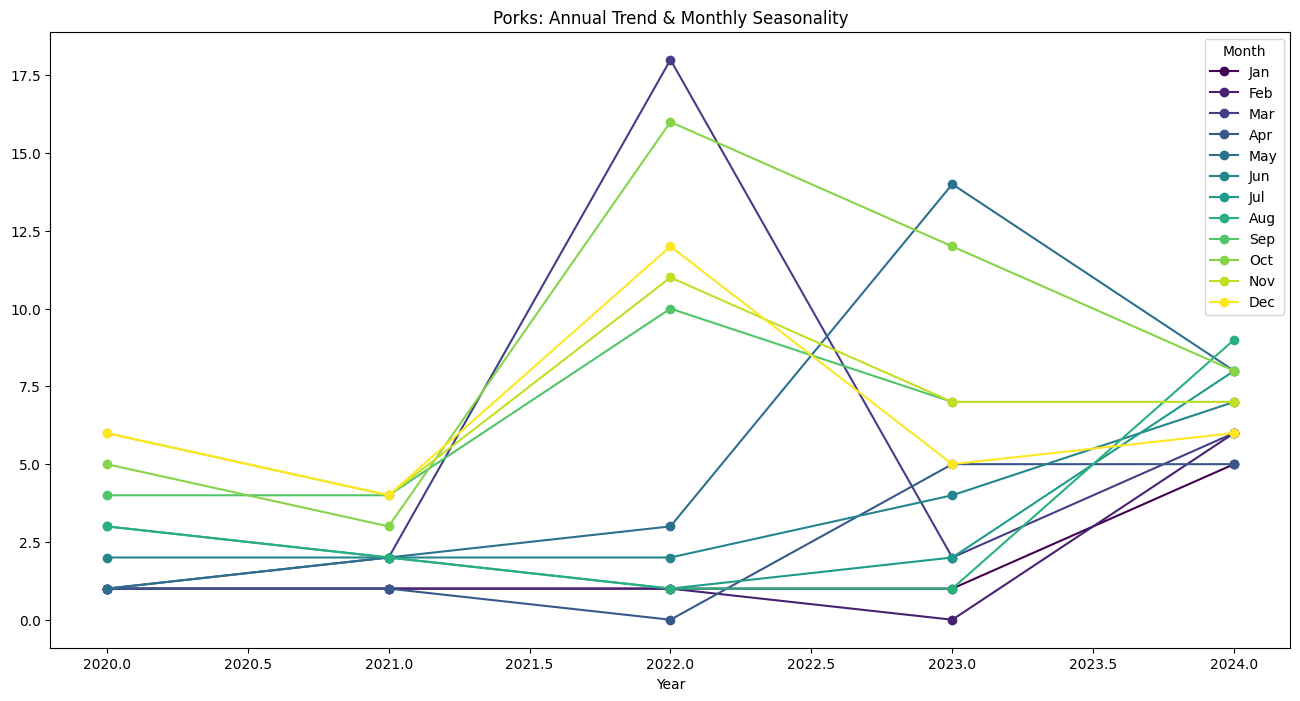

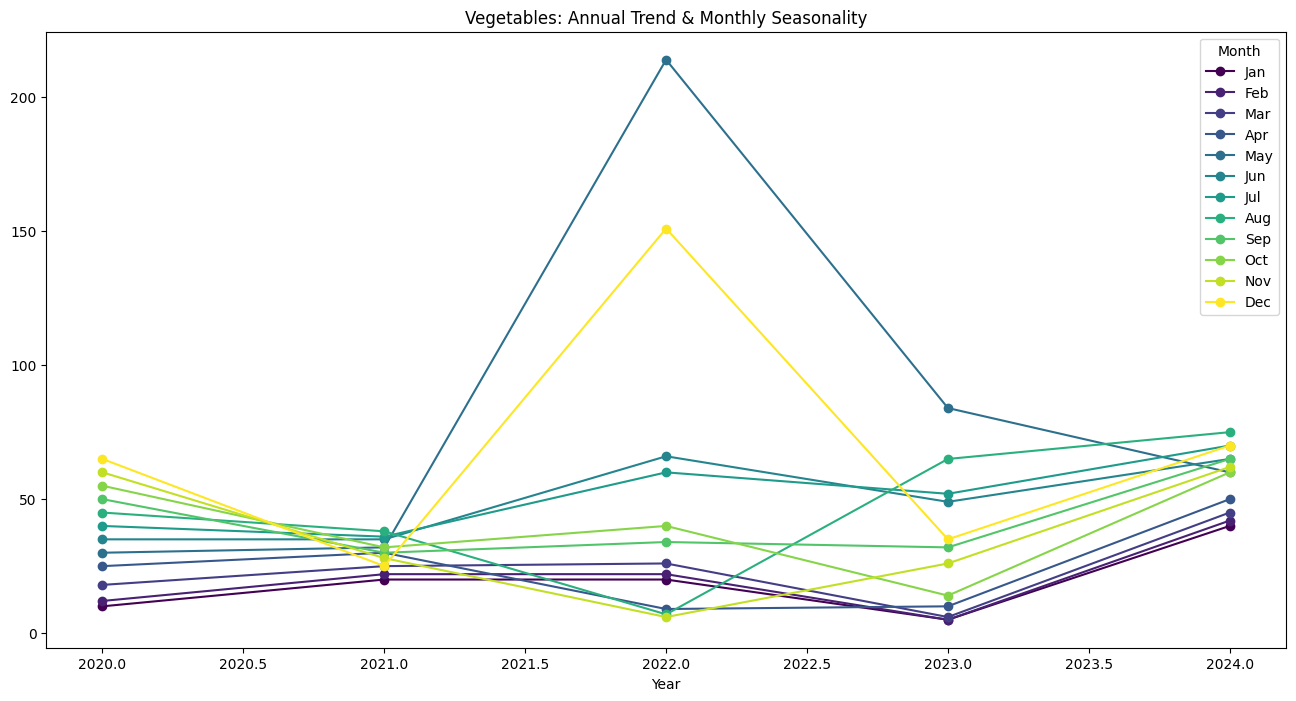

In [12]:
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for product in products:
    fig, ax = plt.subplots(figsize=(16, 8))
    pivot = df.groupby([df["date"].dt.year, df["date"].dt.month])[product].mean().unstack()
    pivot.columns = month_names
    pivot.plot(ax=ax, cmap="viridis", marker="o")

    ax.set_title(f"{product.capitalize()}: Annual Trend & Monthly Seasonality")
    ax.set_xlabel("Year")
    plt.legend(title="Month")

Products decompose

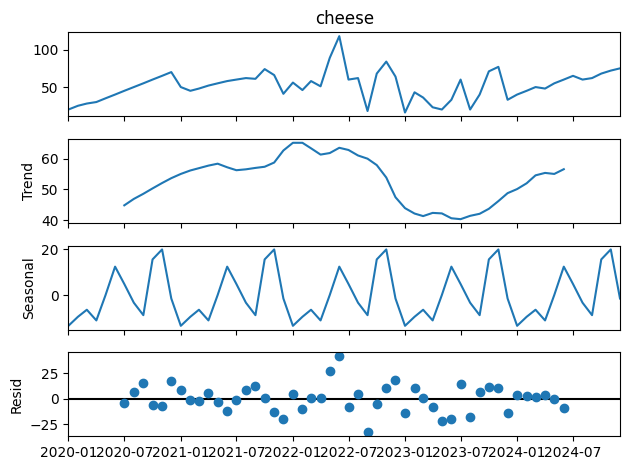

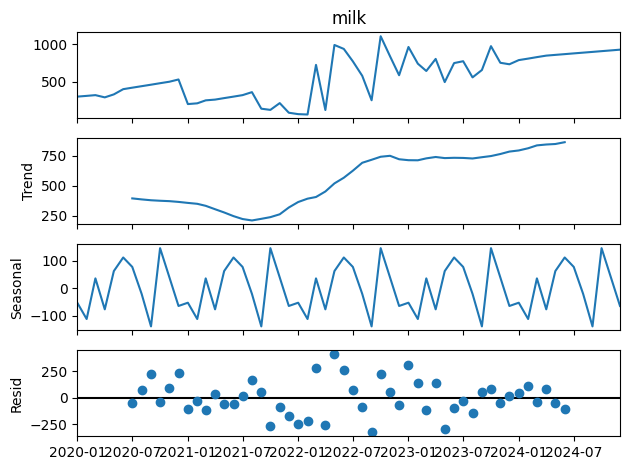

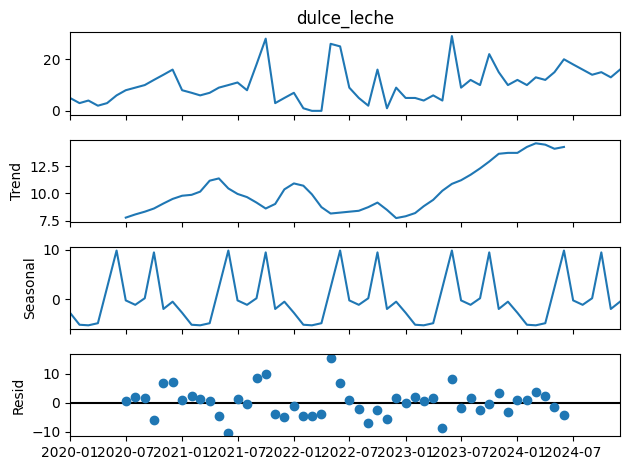

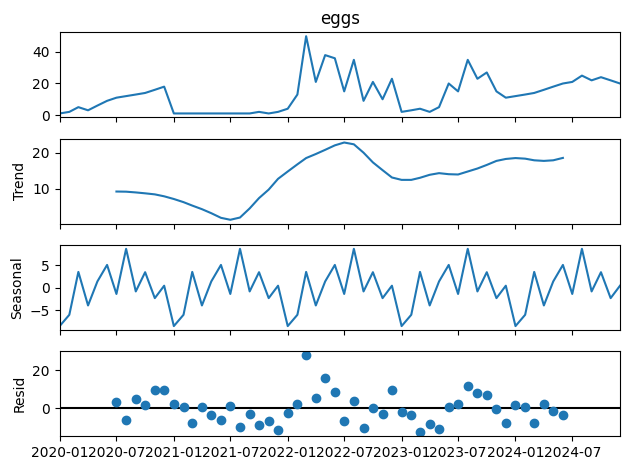

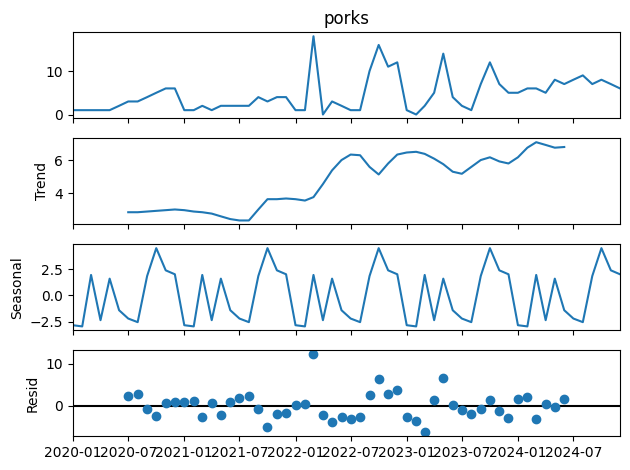

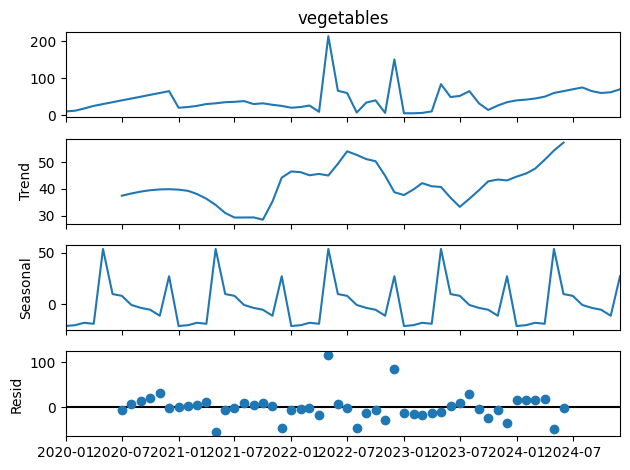

In [13]:
for product in products:
    result = seasonal_decompose(df.set_index("date")[product], model="additive", period=12)
    result.plot()

Monthly Patterns by Year

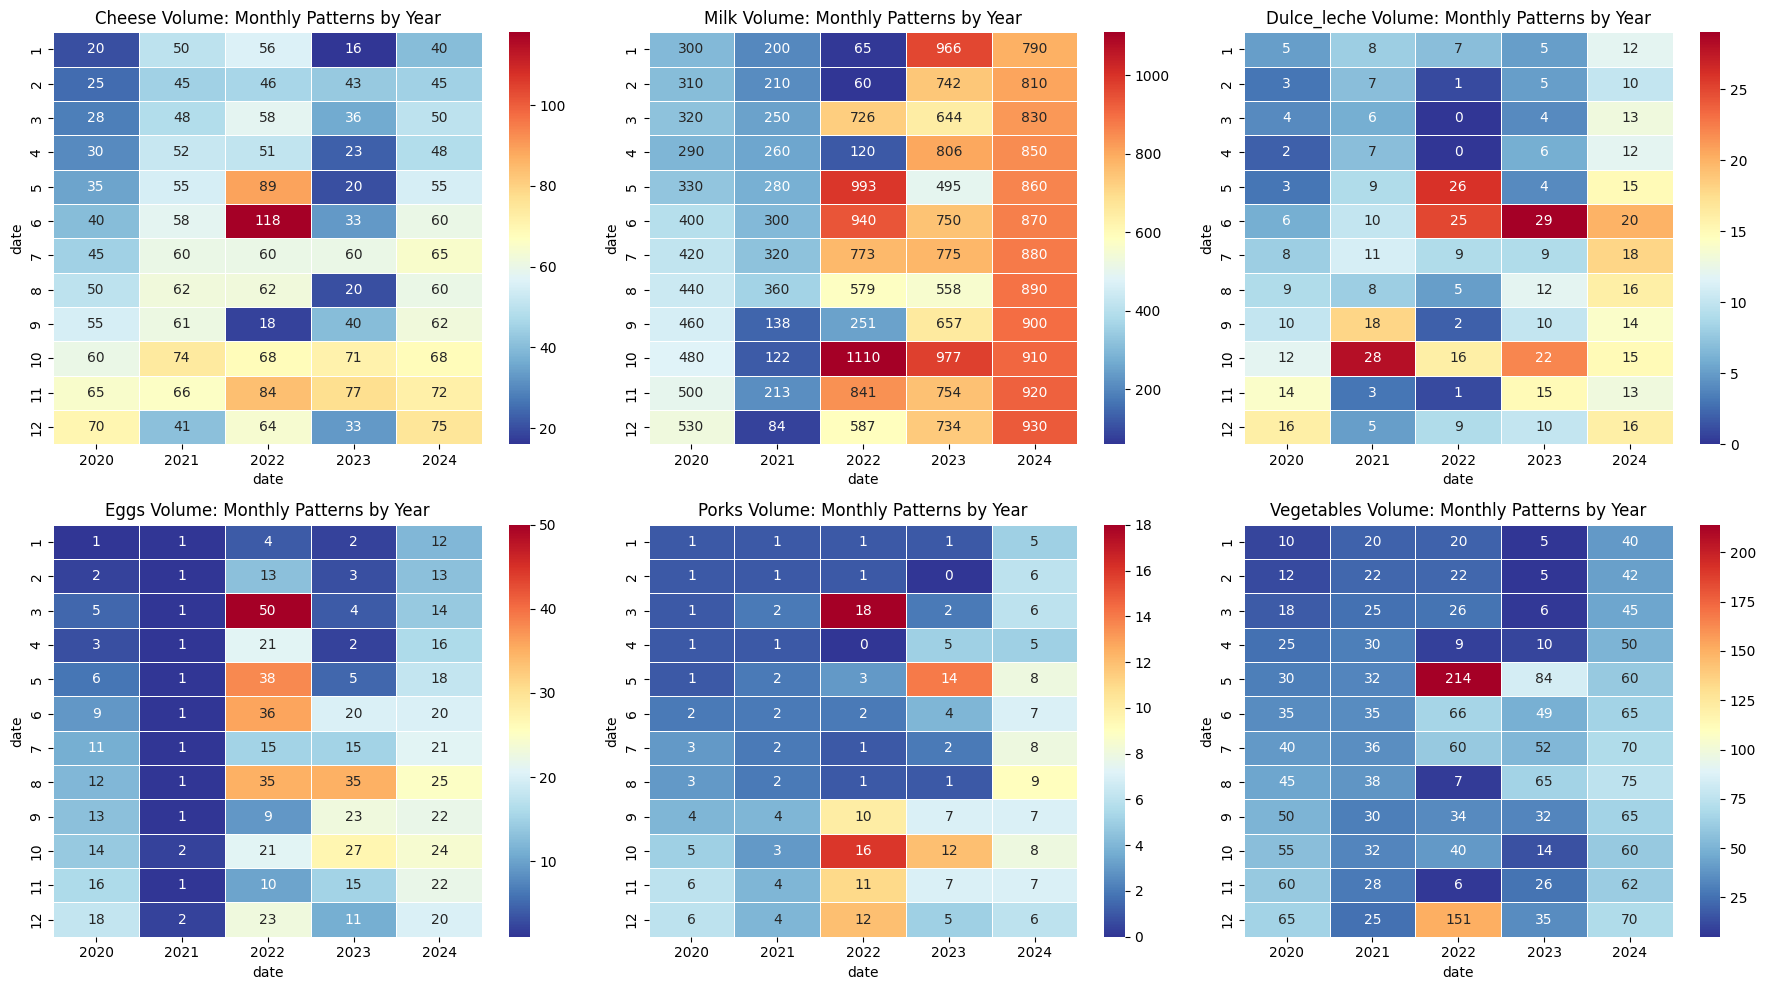

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, product in enumerate(products):
    ax = axes[i]
    pivot = df.pivot_table(index=df["date"].dt.month,
                           columns=df["date"].dt.year,
                           values = product                           
                           )
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="RdYlBu_r", linewidths=.5, ax=ax)
    ax.set_title(f"{product.capitalize()} Volume: Monthly Patterns by Year")
plt.tight_layout()
plt.show()

In [15]:
# Creates a column for season based on Brazil
df["season"] = df['date'].dt.month.map({
    1: 'Summer', 2: 'Summer', 3: 'Summer',
    4: 'Fall', 5: 'Fall', 6: 'Fall',
    7: 'Winter', 8: 'Winter', 9: 'Winter',
    10: 'Spring', 11: 'Spring', 12: 'Spring'
})

Displays the season comparison

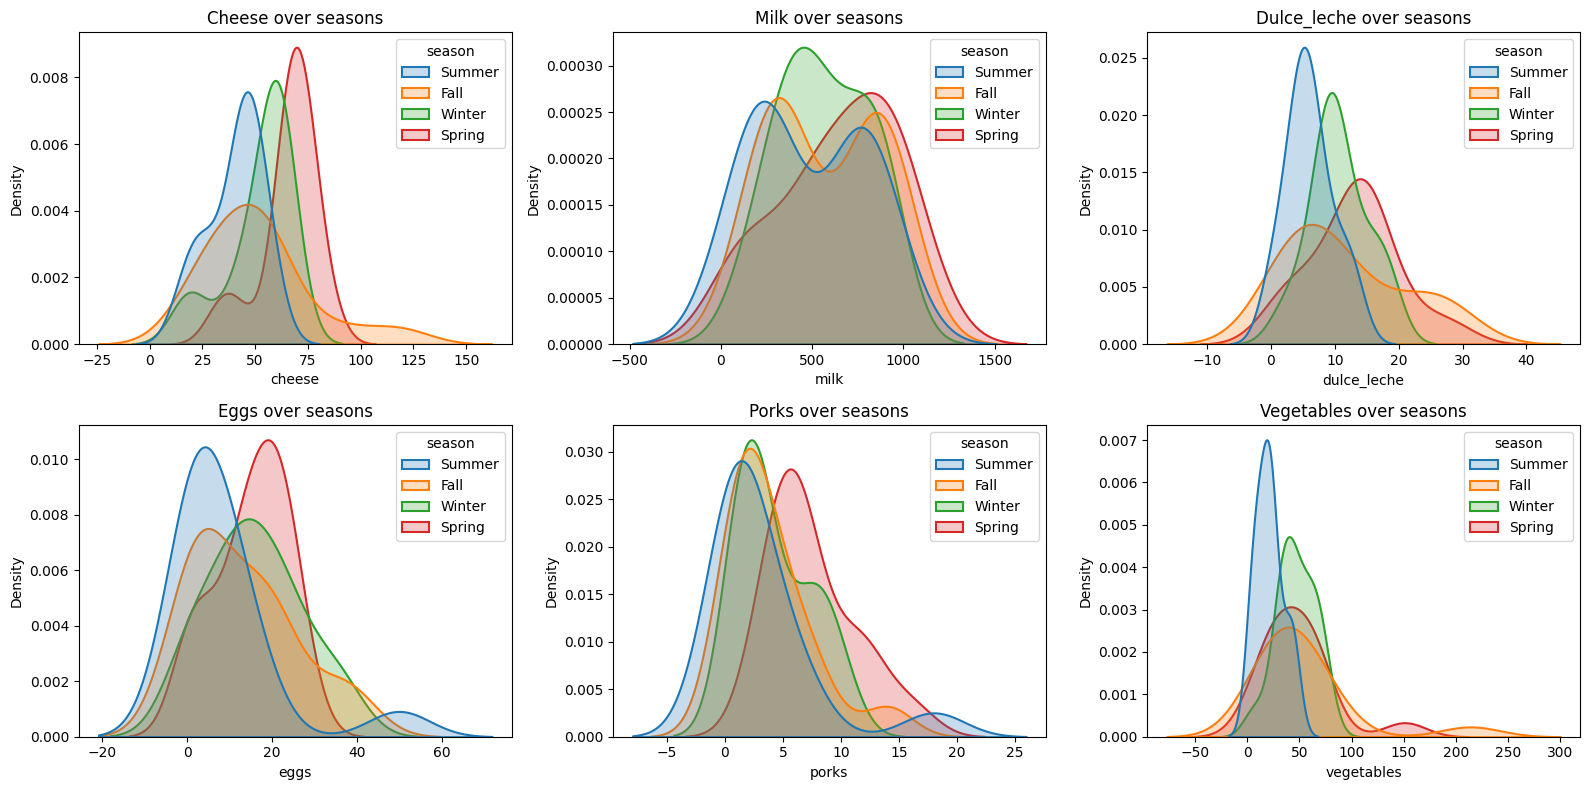

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

for i, product in enumerate(products):
    ax = axes[i]
    sns.kdeplot(data=df, x=product, hue="season", fill=True, linewidth=1.5, ax=ax)
    ax.set_title(f"{product.capitalize()} over seasons")

for j in range(len(products), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Annual Volume - Seasons

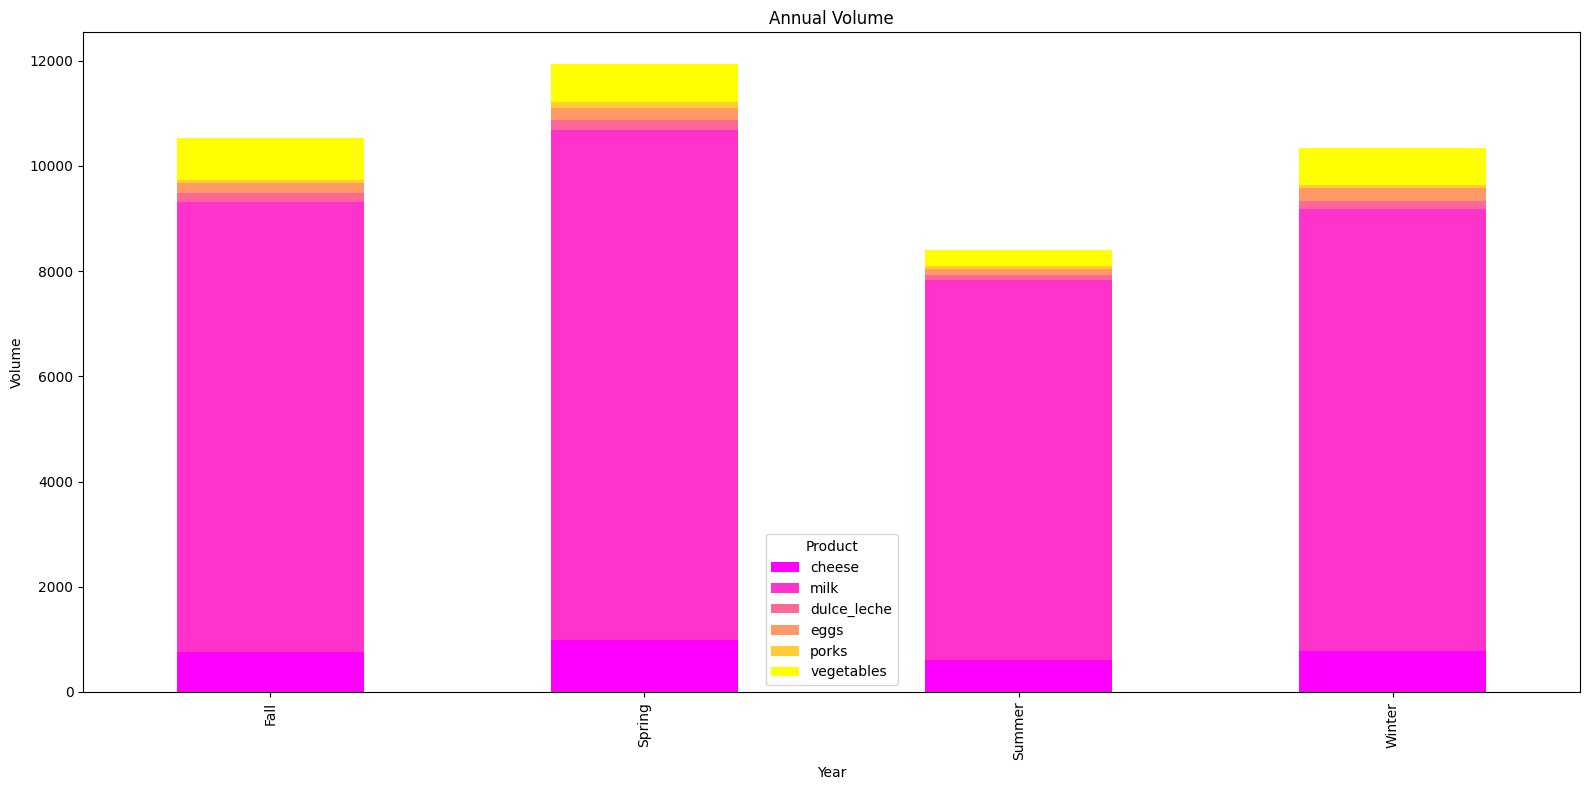

In [17]:
annual_volume = df.groupby("season")[products].sum()

annual_volume.plot(kind="bar", stacked=True, figsize=(16, 8), colormap="spring")
plt.title("Annual Volume")
plt.xlabel("Year")
plt.ylabel("Volume")
plt.legend(title="Product")
plt.tight_layout()
plt.show()